In [1]:
import pandas as pd

In [2]:
df_price = pd.read_csv(r'C:\프로젝트\회사프로젝트\주가예측데이터\005930.KS.csv')
df_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,4514.581543,74195000
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,4122.972656,74680000
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,4152.528809,54390000
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,4093.417480,40305000
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,4263.361328,46880000


In [3]:
# 날짜 datetime으로 변환
pd.to_datetime(df_price['Date'], format='%Y-%m-%d')

df_price['Date'] = pd.to_datetime(df_price['Date'], format='%Y-%m-%d')
df_price['Year'] = df_price['Date'].dt.year
df_price['Month'] = df_price['Date'].dt.month
df_price['Day'] = df_price['Date'].dt.day

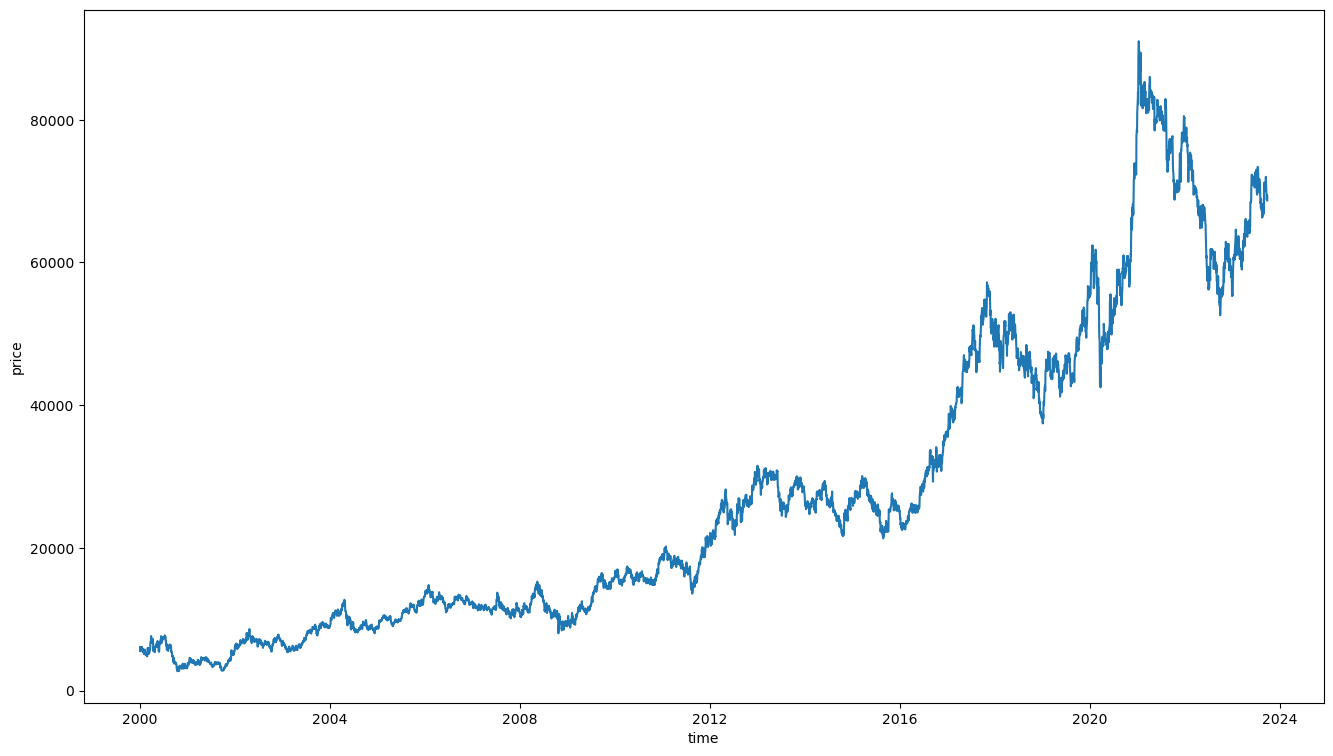

In [4]:
# 주가 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 9))
sns.lineplot(y=df_price['Close'], x=df_price['Date'])
plt.xlabel('time')
plt.ylabel('price')
plt.show()

In [5]:
# 전처리(Normalization) : 0~1 사이의 값으로 변환

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_scaled = scaler.fit_transform(df_price[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(df_scaled)

          Open      High       Low     Close    Volume
0     0.039426  0.035623  0.037207  0.038292  0.451816
1     0.037147  0.035091  0.035599  0.032287  0.454770
2     0.036577  0.032114  0.036288  0.032740  0.331212
3     0.034412  0.030944  0.033762  0.031834  0.245440
4     0.034868  0.032008  0.036288  0.034440  0.285479
...        ...       ...       ...       ...       ...
5951  0.768687  0.718205  0.770326  0.757562  0.066212
5952  0.759572  0.712888  0.762288  0.749632  0.065745
5953  0.749316  0.703318  0.756546  0.748499  0.060274
5954  0.751595  0.711825  0.758842  0.755296  0.082712
5955  0.768687  0.715015  0.757694  0.747366  0.052977

[5956 rows x 5 columns]


In [6]:
# train, test 데이터셋 생성
Test_data = 260
train = df_scaled[:-Test_data]
test = df_scaled[-Test_data:]

print(train.shape)
print(test.shape)

(5696, 5)
(260, 5)


In [7]:
# 데이터셋 생성
import numpy as np
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i + window_size]))
        label_list.append(np.array(label.iloc[i + window_size]))
    return np.array(feature_list), np.array(label_list)

In [8]:
# feature, label 생성
feature_cols = ['Open', 'High', 'Low', 'Volume']
label_cols = ['Close']

train_feature = train[feature_cols]
train_label = train[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 20)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

print(x_train.shape, x_valid.shape)

(4540, 20, 4) (1136, 20, 4)


In [9]:
test_feature, test_label = make_dataset(test[feature_cols], test[label_cols], 20)
print(test_feature.shape, test_label.shape)

(240, 20, 4) (240, 1)


In [10]:
# 모델 생성
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import os

model = Sequential()
model.add(LSTM(16, activation='relu', return_sequences=True, input_shape=(train_feature.shape[1], train_feature.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))

# 모델 학습
optimizer = Adam
model.compile(loss='mean_squared_error', optimizer=optimizer(lr=0.001))
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join('C:\프로젝트\회사프로젝트\주가예측데이터', 'tmp_checkpoint.h5')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, epochs=200, batch_size=16, validation_data=(x_valid, y_valid), callbacks=[early_stop, checkpoint])

Epoch 1/200
284/284 [==============================] - ETA: 0s - loss: 0.0081
Epoch 1: val_loss improved from inf to 0.00056, saving model to C:\프로젝트\회사프로젝트\주가예측데이터\tmp_checkpoint.h5
284/284 [==============================] - 4s 7ms/step - loss: 0.0081 - val_loss: 5.6101e-04
Epoch 2/200
 30/284 [==>...........................] - ETA: 1s - loss: 0.0019

c:\Users\JYP\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


284/284 [==============================] - ETA: 0s - loss: 0.0019
Epoch 2: val_loss improved from 0.00056 to 0.00027, saving model to C:\프로젝트\회사프로젝트\주가예측데이터\tmp_checkpoint.h5
284/284 [==============================] - 2s 6ms/step - loss: 0.0019 - val_loss: 2.6936e-04
Epoch 3/200
275/284 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 3: val_loss did not improve from 0.00027
284/284 [==============================] - 2s 6ms/step - loss: 0.0015 - val_loss: 3.0596e-04
Epoch 4/200
275/284 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 4: val_loss did not improve from 0.00027
284/284 [==============================] - 2s 6ms/step - loss: 0.0013 - val_loss: 6.8566e-04
Epoch 5/200
277/284 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 5: val_loss did not improve from 0.00027
284/284 [==============================] - 2s 6ms/step - loss: 0.0010 - val_loss: 6.8753e-04
Epoch 6/200
283/284 [============================>.] - ETA: 0s - loss: 0.0010


In [11]:
# 가중치 로드
model.load_weights(filename)

# 예측
pred = model.predict(test_feature)

8/8 [==============================] - 0s 2ms/step


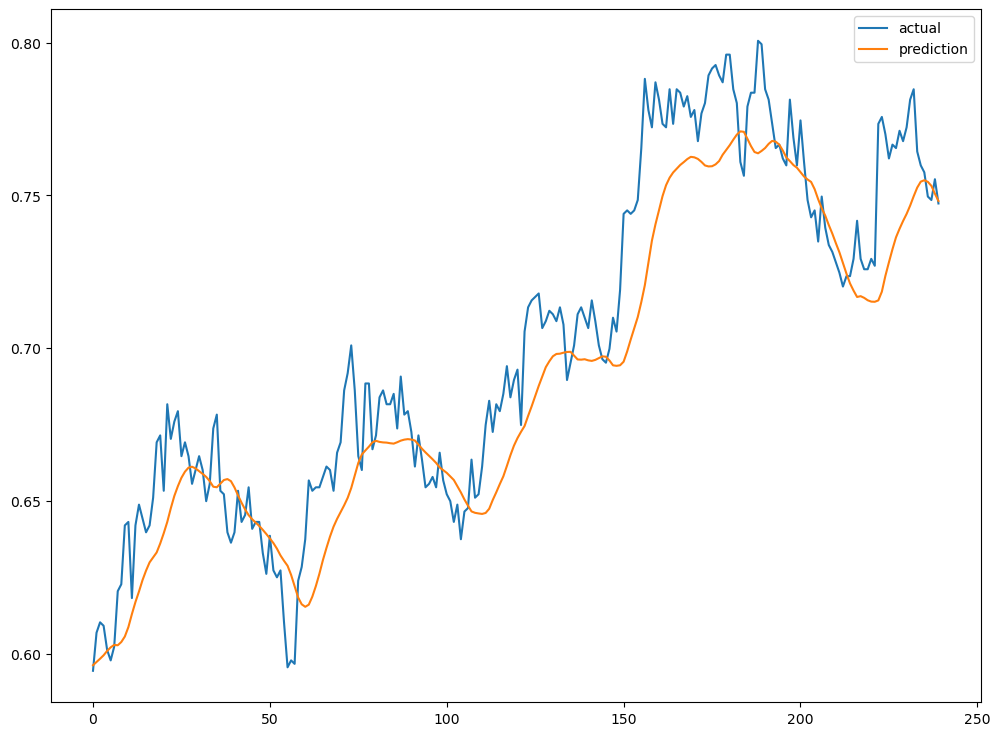

In [12]:
# 실제값과 예측값 비교
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()